In [9]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd

#Sampling
from pyDOE import lhs

# Optimization
import torch
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement
from botorch.models.gp_regression import HeteroskedasticSingleTaskGP # This implements the variance of the y
from botorch.utils.transforms import normalize,unnormalize

## Mixed
from gpytorch.constraints import Interval
from botorch.models import MixedSingleTaskGP
from botorch.optim import optimize_acqf_mixed


In [10]:
def gp_evaluate(model,grid):
    model.eval()
    with torch.no_grad():
        posterior = model.posterior(grid)
    mean = posterior.mean
    var = posterior.variance
    return mean, var


# Define all combinations of variables for triple pair plots
variable_combinations = [('time', 'temp'), ('time', 'sulf'), ('time','anly'), ('temp', 'sulf'), ('temp','anly'), ('sulf', 'anly')]
feature_names = ['time', 'temp', 'sulf', 'anly']

# Function to generate input data based on variable combination
def generate_input_data(A, B, c, d, combination):
    if combination == ('time', 'temp'):
        return torch.tensor(np.array([[A[i, j], B[i, j], c, d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('time', 'sulf'):
        return torch.tensor(np.array([[A[i, j], c, B[i, j], d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)        
    elif combination == ('time', 'anly'):
        return torch.tensor(np.array([[A[i, j], d, B[i, j], c ] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('temp', 'sulf'):
        return torch.tensor(np.array([[d, A[i, j], B[i, j], c] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('temp', 'anly'):
        return torch.tensor(np.array([[d, A[i, j], c, B[i, j]] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('sulf', 'anly'):
        return torch.tensor(np.array([[d, c,A[i, j], B[i, j]] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)

def staircase_plot_with_histograms(select, means, var, train_x, train_y, train_yvar, test_x, color, name):
    if select == 'mean':
        versions = means
        cmap_name = color
        y = train_y.numpy()
    elif select == 'var':
        versions = [var] * len(means)  # Use the same variance for all means
        cmap_name = 'seismic'
        y = train_yvar.numpy()

    num_features = train_x.shape[1]  # Assuming 4D input
    feature_names = ["time", "temp", "sulf", "anly"]
    
    fig, axes = plt.subplots(num_features, num_features, figsize=(12, 10))
    count = 0
    for i in range(num_features):
        for j in range(num_features):
            ax = axes[i, j]
            if i < j:  # Upper triangle (leave empty)
                ax.axis('off')
            elif i == j:  # Diagonal (histograms)
                ax.hist(train_x[:, i].numpy(), bins=10, color='gray', edgecolor='black', alpha=0.7)
                ax.set_xlabel(feature_names[i])
                ax.set_box_aspect(1)  # Set the aspect ratio to be equal (cube-shaped)
                ax.set_ylabel("Frequency")
            else:  # Lower triangle (pairwise scatter plots)
                for version in versions:
                    ax.scatter(train_x[:, j].numpy(), train_x[:, i].numpy(), c=y, cmap=cmap_name, s=50, alpha=0.5,marker='o')
                    sc = ax.contourf(A, B, means[count].reshape(num_points, num_points), cmap=cmap_name, alpha=0.7, levels=10,vmax=1, vmin=0)
                fig.colorbar(sc, ax=ax, orientation='vertical')
                ax.set_xlabel(feature_names[j])
                ax.set_ylabel(feature_names[i])
                ax.set_box_aspect(1)
                count += 1
            plt.tight_layout()

>## Import Data from Round 1 

In [ ]:
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

# import data from csv
data_R1 = pd.read_csv('../../Experiment_Round1/extracted_data_round1.csv')

# average and standard deviation of the repeats
avg_data01 = data_R1.groupby('01_time').mean().reset_index()[['01_time','01_temp','01_sulf','01_anly','01_yield product']].rename(columns = {'01_time':"time",'01_temp':"temp",'01_sulf':"sulf",'01_anly':"anly",'01_yield product':"yield product"})
std_data01 = data_R1.groupby('01_time').std().reset_index()[['01_time','01_temp','01_sulf','01_anly','01_yield product']].rename(columns = {'01_time':"time",'01_temp':"temp",'01_sulf':"sulf",'01_anly':"anly",'01_yield product':"yield product"})

>## Build Gaussian Process Regression

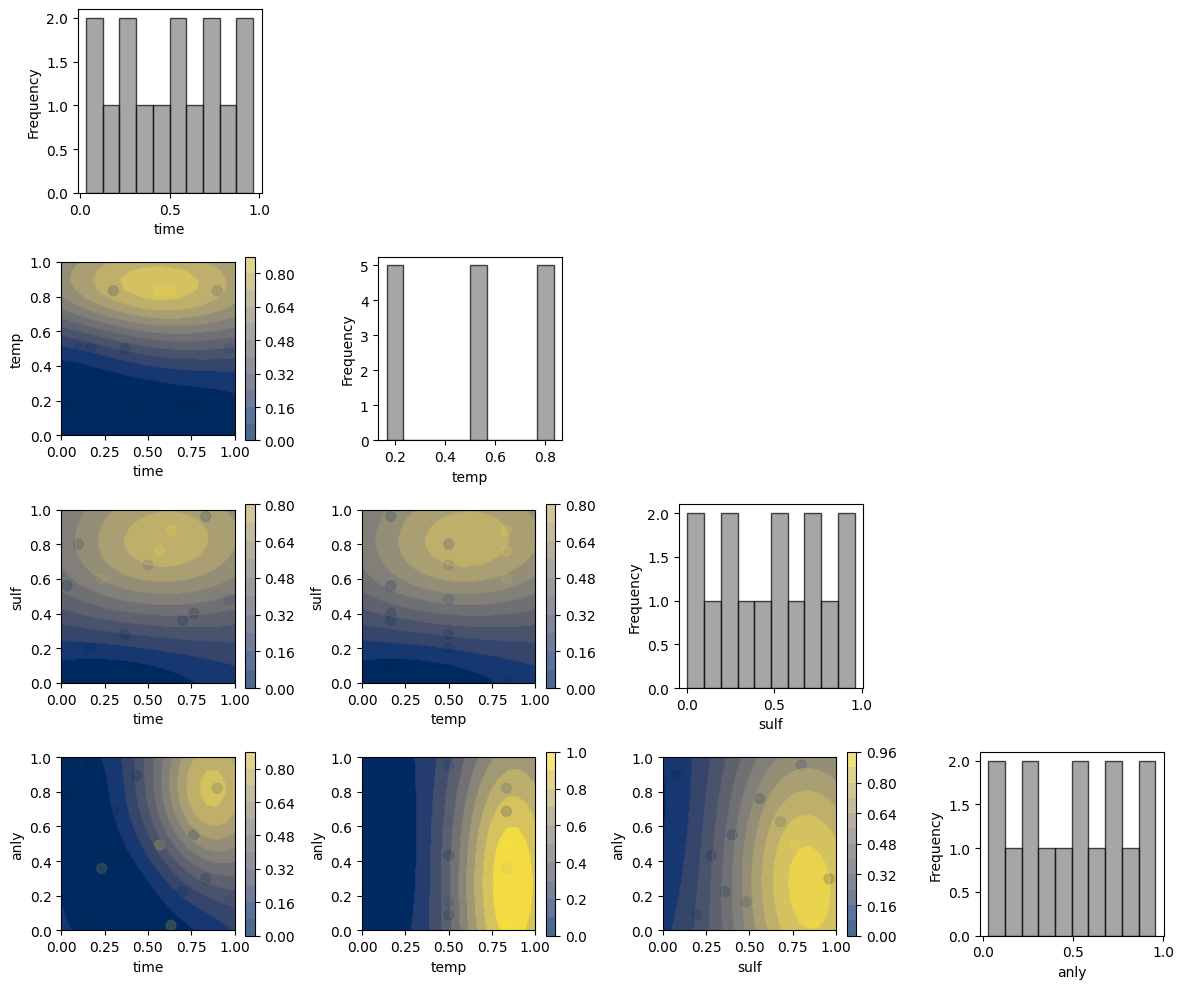

In [19]:
# Define the bounds for continuous variables
bounds = torch.tensor([
    [30.0, 20.0, 75.0, 33.0],  # Lower bounds for the 3 continuous variables
    [600.0, 170.0,100.0, 100.0]   # Upper bounds for the 3 continuous variables
])

x = torch.tensor([avg_data01['time'],avg_data01['temp'],avg_data01['sulf'],avg_data01['anly']],dtype=torch.float32).T#
norm_x = normalize(x, bounds)
y = torch.tensor(avg_data01['yield product'],dtype=torch.float32).reshape(-1,1)
yvar = torch.tensor(std_data01['yield product'],dtype=torch.float32).reshape(-1,1)

train_x = torch.tensor(norm_x, dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y, dtype=dtype)
train_yvar = torch.tensor(yvar, dtype=dtype)

gp_model = HeteroskedasticSingleTaskGP(train_x, train_y,train_yvar).to(device=device, dtype=dtype)
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

# Visualized the Model
# Generate a grid
num_points = 20  # Points per axis for plotting
a = np.linspace(0, 1, num_points)
b = np.linspace(0, 1, num_points)
c_slices = np.linspace(0, 1, 12)  # Slicing variable
c_fixed = 0.75  # Example fixed value for c - three temperatures
d_fixed =  0.75 # Example fixed value for d - three temperatures

# # Create meshgrid for a, b
A, B = np.meshgrid(a, b)

mean_values = []
var_values = []
for combination in variable_combinations:
    input_data = generate_input_data(A, B, c_fixed, d_fixed, combination)
    mean, var =  gp_evaluate(gp_model, input_data)
    mean_values.append(mean)
    var_values.append(var)

staircase_plot_with_histograms('mean', mean_values, var_values, train_x, train_y, train_yvar , input_data, 'cividis', f"Combination: {combination}")


>## BO (batch size = 3) for Temp 

In [ ]:
# Add a random seed
torch.manual_seed(42)

# Change Batch Size
batch_size = 3 #train_size
# For EI 
best_f = torch.tensor(1.0 ,dtype=dtype) 
# Define bounds
bounds = torch.tensor([
    [30.0, 20.0, 75.0, 33.0],  # Lower bounds for the 3 continuous variables
    [600.0, 170.0,100.0, 100.0]   # Upper bounds for the 3 continuous variables
])
BO_bounds = torch.tensor([
    [0.0, 0.0, 0.0, 0.0],  # Lower bounds for the 3 continuous variables
    [1.0, 1.0,1.0, 1.0]   # Upper bounds for the 3 continuous variables
])


Centroids of Temperature Clusters:
tensor([155., 147.,  71.])


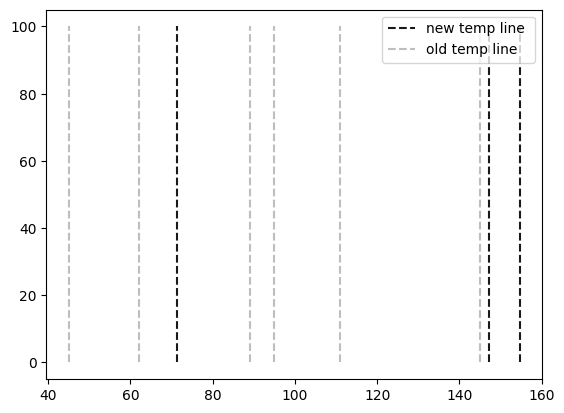

In [21]:
# Aquisition function
qEI = qExpectedImprovement(model=gp_model, best_f=best_f)

# Optimize
candidates_T, _ = optimize_acqf(
    acq_function=qEI,
    bounds=BO_bounds,
    q=batch_size,
    num_restarts=1,
    raw_samples=100,
    options={"dtype": dtype, "device": device}
)

print("Centroids of Temperature Clusters:")
centroids = unnormalize(candidates_T[:,1],[20,170])
print(centroids.round())

old = [45,95,145,111,62,89]
plt.vlines(centroids,0,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.legend(['new temp line ','old temp line'])

>## Mixed BO 4D + temps

In [22]:
# BO parameters for MIXED
batch_size = 15
# Discrete variable choices from 1D BO
discrete_choices= normalize(centroids,[20,170]).numpy().T
fixed_features_list = [{1: float(discrete_choices[0])},{1: float(discrete_choices[1])},{1: float(discrete_choices[2])}]#[{0: float(choice)} for choice in discrete_choices]
fixed_features_list

[{1: 0.8973732590675354}, {1: 0.8480501174926758}, {1: 0.3421196937561035}]

In [ ]:
# Add a random seed
torch.manual_seed(42)

mixed_GP = MixedSingleTaskGP(train_x, train_y, cat_dims=[1],train_Yvar=train_yvar)
mll = ExactMarginalLogLikelihood(mixed_GP.likelihood, mixed_GP)
fit_gpytorch_model(mll)

qEI = qExpectedImprovement(model=mixed_GP, best_f=best_f)

# Re-run the BO for the mixed with constrained temps
candidate_mixed, _ = optimize_acqf_mixed(
    acq_function=qEI,
    bounds=BO_bounds,
    q=batch_size,
    fixed_features_list=fixed_features_list,
    num_restarts=10,
    raw_samples=15,
    options={"dtype": dtype, "device": device}
)
unnorm_candidates = unnormalize(candidate_mixed,bounds)

data = {
    'time': unnorm_candidates[:,0].round(),
    'temp': unnorm_candidates[:,1].round(),
    'sulf': unnorm_candidates[:,2].round(),
    'anly': unnorm_candidates[:,3].round()
}
data_df = pd.DataFrame(data)
data_df

,time,temp,sulf,anly
0,89.0,155.0,98.0,41.0
1,213.0,155.0,79.0,68.0
2,327.0,147.0,98.0,51.0
3,530.0,147.0,75.0,88.0
4,333.0,71.0,82.0,43.0
5,199.0,71.0,98.0,66.0
6,433.0,71.0,87.0,79.0
7,140.0,71.0,75.0,70.0
8,533.0,147.0,92.0,78.0
9,108.0,147.0,84.0,73.0


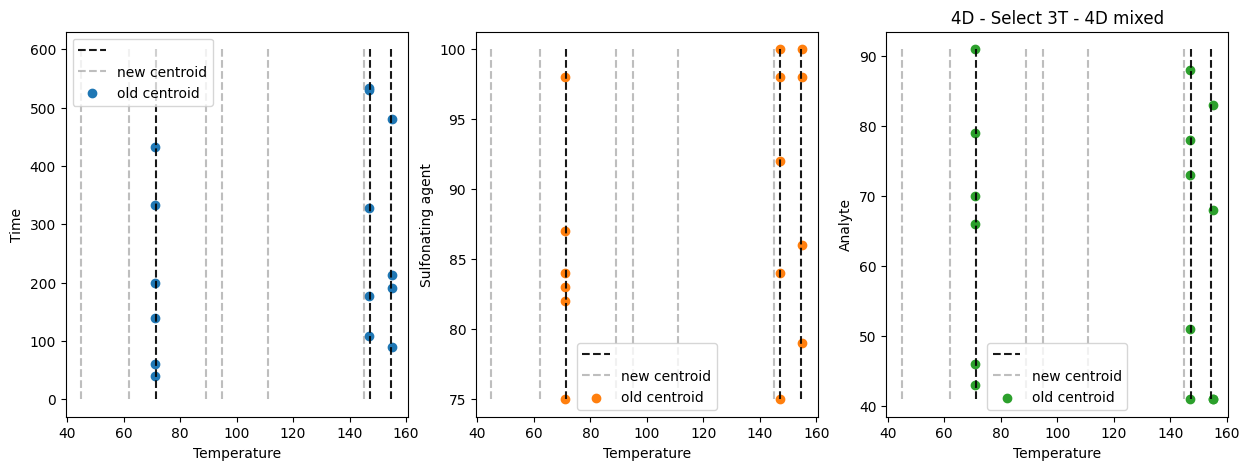

,time,temp,sulf,anly
0,89.0,155.0,98.0,41.0
1,213.0,155.0,79.0,68.0
2,327.0,147.0,98.0,51.0
3,530.0,147.0,75.0,88.0
4,333.0,71.0,82.0,43.0
5,199.0,71.0,98.0,66.0
6,433.0,71.0,87.0,79.0
7,140.0,71.0,75.0,70.0
8,533.0,147.0,92.0,78.0
9,108.0,147.0,84.0,73.0


In [28]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.vlines(centroids,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(data_df['temp'],data_df['time'],color = 'tab:blue')
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.legend(['','new centroid','old centroid'])

plt.subplot(1,3,2)
plt.vlines(centroids,data_df['sulf'].min(),data_df['sulf'].max(), color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,data_df['sulf'].min(),data_df['sulf'].max(), color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(data_df['temp'],data_df['sulf'],color = 'tab:orange')
plt.xlabel('Temperature')
plt.ylabel('Sulfonating agent')
plt.legend(['','new centroid','old centroid'])

plt.subplot(1,3,3)
plt.vlines(centroids,data_df['anly'].min(),data_df['anly'].max(), color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,data_df['anly'].min(),data_df['anly'].max(), color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.scatter(data_df['temp'],data_df['anly'],color = 'tab:green')
plt.xlabel('Temperature')
plt.ylabel('Analyte')
plt.legend(['','new centroid','old centroid'])

plt.title("4D - Select 3T - 4D mixed")
plt.show()


data_df